<a href="https://colab.research.google.com/github/froggagul/CGAN/blob/master/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn, optim, FloatTensor, LongTensor
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt

devicename = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(devicename)
print(f'Training GAN Model on {device} with MNIST Data\n{"=" * 44}')

opt = {
    'batch_size': 100,
    'label_size': 10,
    'initial_vector_size': 100,
    'num_epoch': 200
}

transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,))
])

mnist_train = datasets.MNIST(root="MNIST/",
                             train=True,
                             download=True,
                             transform=transform)
# mnist_test = datasets.MNIST(root="MNIST/",
#                              train=True,
#                              download=True,
#                              transform=transform)

train_loader = DataLoader(dataset=mnist_train,
                        batch_size=opt['batch_size'],
                        shuffle=True)
# test_loader = DataLoader(dataset=mnist_test,
#                        batch_size=opt['batch_size'],
#                        shuffle=True)


Training GAN Model on cuda with MNIST Data


In [ ]:
# utils
def InitialVector():
  return torch.randn(opt['batch_size'], opt['initial_vector_size'], device=device)

def RandomLabel():
  return Variable(torch.LongTensor(np.random.randint(0, opt['label_size'], opt['batch_size']))).to(device)

def make_one_hot(labels):
    one_hot = torch.FloatTensor(opt['batch_size'], opt['label_size']).zero_().to(device)
    target = one_hot.scatter_(1, labels.unsqueeze(1), 1)
    target = Variable(target)
    return target

# model - Generator and Discriminator
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
      nn.Linear(opt['label_size'] + opt['initial_vector_size'], 256),
      nn.ReLU(),
      # nn.Dropout(0.1),
      nn.Linear(256,512),
      nn.ReLU(),
      # nn.Dropout(0.1),
      nn.Linear(512,1024),
      nn.ReLU(),
      nn.Linear(1024, 784),
      nn.Tanh()
    )
  def forward(self, z, labels):
    z = z.view(z.size(0), opt['initial_vector_size'])
    labels = make_one_hot(labels)
    z = torch.cat([z, labels], 1)
    out = self.main(z)
    return out.view(z.size(0), 28, 28)

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
      nn.Linear(784 + opt['label_size'], 1024),
      nn.ReLU(),
      nn.Dropout(p=0.1),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Dropout(p=0.1),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Dropout(p=0.1),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )
  def forward(self, x, labels):
    x = x.view(x.size(0), 784)
    labels = make_one_hot(labels)
    x = torch.cat([x, labels], 1)
    out = self.main(x)
    return out

generator = Generator().to(device)
discriminator = Discriminator().to(device)
# optimizers
g_optimizer = optim.Adam(generator.parameters(), lr = 0.0001)
d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0001)

# cost/loss function
criterion = nn.BCELoss()

def imgshow(epoch):
  generator.eval()
  z = Variable(torch.randn(opt['label_size'] ** 2, opt['label_size'] ** 2)).to(device)
  labels = torch.Tensor(100).fill_(0).long().to(device)
  for i in range(opt['label_size']):
    for j in range(opt['label_size']):
      labels[10*i+j] = j
  images = generator(z, labels).unsqueeze(1)
  images = images.cpu().detach()
  grid = make_grid(images, nrow=opt['label_size'], normalize=True)
  save_image(grid, "result/%d.png"%(epoch+1))
  fig, ax = plt.subplots(figsize=(opt['label_size'],opt['label_size']))
  ax.imshow(grid.permute(1, 2, 0).data, cmap='binary')
  ax.axis('off')
  plt.show()

# training
def train(epoch):
  print('starting {}/{}'.format(epoch, opt['num_epoch']))
  generator.train()
  discriminator.train()
  avg_loss = [0, 0]

  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

    # maximize V(D,G) on D's sight
    g_optimizer.zero_grad()
    z = InitialVector()
    fake_labels = RandomLabel()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(opt['batch_size'])).to(device))
    g_loss.backward()
    g_optimizer.step()

    # minimize V(D, G) on G's sight
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(data, target)
    real_loss = criterion(real_validity, Variable(torch.ones(opt['batch_size'])).to(device))
    
    # train with fake images
    z = InitialVector()
    fake_labels = RandomLabel()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(opt['batch_size'])).to(device))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    avg_loss[0] += g_loss
    avg_loss[1] += d_loss
    # if(batch_idx%200==0):
    #   print(f'{batch_idx}th batch\'s loss : generator_loss: {g_loss} discriminator_loss: {d_loss}')
  avg_loss[0] /= len(train_loader)
  avg_loss[1] /= len(train_loader)
  return avg_loss

# main
if __name__=="__main__":
  for epoch in range(opt['num_epoch']):
    avg_loss = train(epoch)
    print(f'epoch {epoch} result: d_loss: {avg_loss[1]} g_loss: {avg_loss[0]}')
    if (epoch % 25 == 0):
      imgshow(epoch)

starting 200/200


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


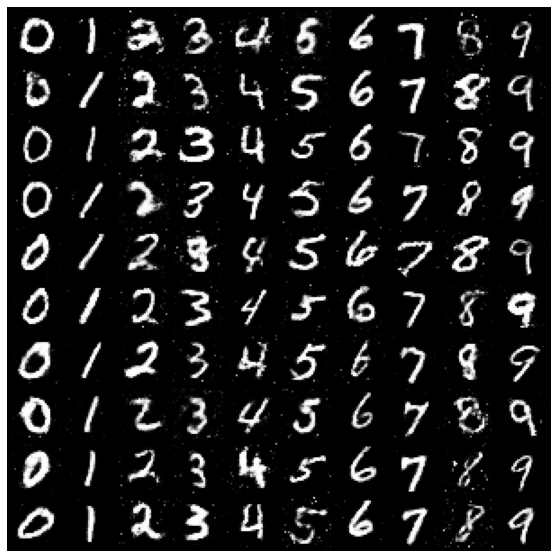

In [ ]:
train(200)
imgshow(200)

In [ ]:
from google.colab import files

files.download('./result/1.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r ./result.zip ./result

  adding: result/ (stored 0%)
  adding: result/26.png (deflated 4%)
  adding: result/176.png (deflated 4%)
  adding: result/126.png (deflated 4%)
  adding: result/1.png (deflated 9%)
  adding: result/201.png (deflated 4%)
  adding: result/101.png (deflated 4%)
  adding: result/51.png (deflated 4%)
  adding: result/151.png (deflated 4%)
  adding: result/76.png (deflated 4%)


## reference
[cgan-paper](https://arxiv.org/pdf/1411.1784.pdf)  
[understanding-pytorch-scatter](https://medium.com/@yang6367/understand-torch-scatter-b0fd6275331c)

